# 3D Multi-class Segmentation with SwinUNETR  (Muscle, Fat (subcut and internal), psoas)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR04.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                      | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.88it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 171, 97]), label shape: torch.Size([1, 250, 171, 97])


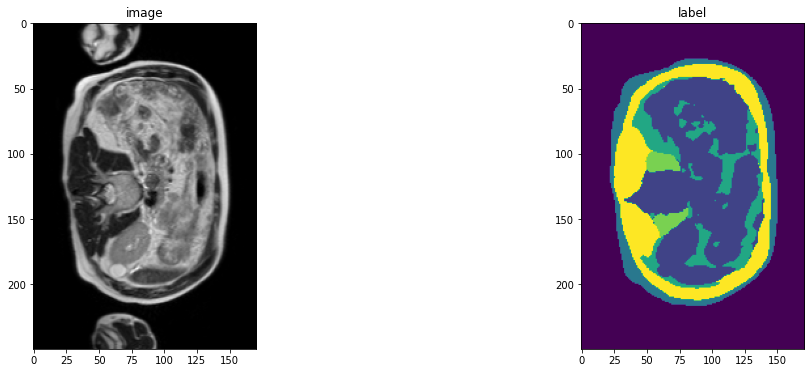

In [8]:
slice_map = {
    "A029_v4_T2W.nii.gz": 10,
    "A029_v4_T2W.nii.gz": 8,
    "A029_v4_T2W.nii.gz": 6
}
case_num = 3
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [9]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR07_swinUNetR_Jan24.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR07_swinUNetR_Jan24.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                     | 0/7 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=1.78497):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:21<00:04,  4.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6323643582207816 Current Avg. Dice: 0.6323643582207816


Training (500 / 70000 Steps) (loss=1.26905):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:19<00:13,  4.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.683203569480351 Current Avg. Dice: 0.683203569480351


Training (750 / 70000 Steps) (loss=1.20142):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:17<00:22,  4.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7107581836836678 Current Avg. Dice: 0.7107581836836678


Training (1000 / 70000 Steps) (loss=1.30602):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:16<00:35,  5.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7268340928213937 Current Avg. Dice: 0.7268340928213937


Training (1250 / 70000 Steps) (loss=0.94383):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:55,  6.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.73180433682033 Current Avg. Dice: 0.73180433682033


Training (1500 / 70000 Steps) (loss=1.05166):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:21, 12.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7366574917520795 Current Avg. Dice: 0.7366574917520795


Training (1750 / 70000 Steps) (loss=0.72656):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7482878480638776 Current Avg. Dice: 0.7482878480638776


Training (2000 / 70000 Steps) (loss=0.90691):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7503302778516497 Current Avg. Dice: 0.7503302778516497


Training (2250 / 70000 Steps) (loss=0.83787):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7503302778516497 Current Avg. Dice: 0.7435363020215716


Training (2500 / 70000 Steps) (loss=0.74652):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:16<00:34,  4.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7858550207955497 Current Avg. Dice: 0.7858550207955497


Training (2750 / 70000 Steps) (loss=1.11607):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8309357336589268 Current Avg. Dice: 0.8309357336589268


Training (3000 / 70000 Steps) (loss=0.52678):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:20, 12.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8643266303198678 Current Avg. Dice: 0.8643266303198678


Training (3250 / 70000 Steps) (loss=0.65726):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.879461944103241 Current Avg. Dice: 0.879461944103241


Training (3500 / 70000 Steps) (loss=0.62737):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:13,  4.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8873291271073478 Current Avg. Dice: 0.8873291271073478


Training (3750 / 70000 Steps) (loss=0.56496):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8873291271073478 Current Avg. Dice: 0.8863459825515747


Training (4000 / 70000 Steps) (loss=0.69845):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:16<00:34,  4.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8873291271073478 Current Avg. Dice: 0.884241351059505


Training (4250 / 70000 Steps) (loss=0.44901):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:55,  6.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8893973657063076 Current Avg. Dice: 0.8893973657063076


Training (4500 / 70000 Steps) (loss=0.77351):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:21, 12.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8893973657063076 Current Avg. Dice: 0.8868040357317243


Training (4750 / 70000 Steps) (loss=1.24239):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8893973657063076 Current Avg. Dice: 0.8883786031178066


Training (5000 / 70000 Steps) (loss=0.63377):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:13,  4.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8942309447697231 Current Avg. Dice: 0.8942309447697231


Training (5250 / 70000 Steps) (loss=0.44636):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8942309447697231 Current Avg. Dice: 0.8933953727994647


Training (5500 / 70000 Steps) (loss=0.51656):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:16<00:34,  4.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8954068848064968 Current Avg. Dice: 0.8954068848064968


Training (5750 / 70000 Steps) (loss=0.41105):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:54,  6.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8954068848064968 Current Avg. Dice: 0.8933499114853996


Training (6000 / 70000 Steps) (loss=0.50194):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:20, 12.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.9010282840047564


Training (6250 / 70000 Steps) (loss=0.37121):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:21<00:04,  4.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.8934818846838815


Training (6500 / 70000 Steps) (loss=0.52986):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.8992586561611721


Training (6750 / 70000 Steps) (loss=0.42298):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.9001401833125523


Training (7000 / 70000 Steps) (loss=0.43965):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.8962749242782593


Training (7250 / 70000 Steps) (loss=0.56527):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:55,  6.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.8999338660921369


Training (7500 / 70000 Steps) (loss=0.44231):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:21, 12.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9010282840047564 Current Avg. Dice: 0.8995939237730843


Training (7750 / 70000 Steps) (loss=0.42770):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.902572010244642


Training (8000 / 70000 Steps) (loss=0.48455):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.900309715952192


Training (8250 / 70000 Steps) (loss=0.43946):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.9004485947745187


Training (8500 / 70000 Steps) (loss=0.45017):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:15<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.9005280647959027


Training (8750 / 70000 Steps) (loss=0.41056):  25%|████████████████████████████▎                                                                                    | 3/12 [00:14<00:56,  6.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.8980040550231934


Training (9000 / 70000 Steps) (loss=0.54895):   8%|█████████▍                                                                                                       | 1/12 [00:12<02:19, 12.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.8994021245411464


Training (9250 / 70000 Steps) (loss=0.44977):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:20<00:04,  4.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.9005422251565116


Training (9500 / 70000 Steps) (loss=0.32399):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:19<00:12,  4.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.8998375109263829


Training (9750 / 70000 Steps) (loss=0.43329):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.9024876526423863


Training (10000 / 70000 Steps) (loss=0.28093):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.897296564919608


Training (10250 / 70000 Steps) (loss=0.32207):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.8994314159665789


Training (10500 / 70000 Steps) (loss=0.41391):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.902572010244642 Current Avg. Dice: 0.8989856583731515


Training (10750 / 70000 Steps) (loss=0.45561):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9035773021834237 Current Avg. Dice: 0.9035773021834237


Training (11000 / 70000 Steps) (loss=0.36338):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9035773021834237 Current Avg. Dice: 0.8972038456371852


Training (11250 / 70000 Steps) (loss=0.34027):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.905425488948822


Training (11500 / 70000 Steps) (loss=0.42902):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9053843702588763


Training (11750 / 70000 Steps) (loss=0.38921):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:54,  6.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.8984648074422564


Training (12000 / 70000 Steps) (loss=0.35977):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9044465167181832


Training (12250 / 70000 Steps) (loss=0.35946):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9043620909963336


Training (12500 / 70000 Steps) (loss=0.24780):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.8999025566237313


Training (12750 / 70000 Steps) (loss=0.32090):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.8974572079522269


Training (13000 / 70000 Steps) (loss=0.26978):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9034234200205121


Training (13250 / 70000 Steps) (loss=0.56019):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9008430072239467


Training (13500 / 70000 Steps) (loss=0.29128):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:21, 12.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9032290748187474


Training (13750 / 70000 Steps) (loss=0.47790):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.905425488948822 Current Avg. Dice: 0.9044670122010368


Training (14000 / 70000 Steps) (loss=0.30901):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9080991574696132 Current Avg. Dice: 0.9080991574696132


Training (14250 / 70000 Steps) (loss=0.26537):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9097406012671334


Training (14500 / 70000 Steps) (loss=0.28758):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9059118543352399


Training (14750 / 70000 Steps) (loss=0.36702):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9054759570530483


Training (15000 / 70000 Steps) (loss=0.30595):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9064904536519732


Training (15250 / 70000 Steps) (loss=0.42138):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9057266201291766


Training (15500 / 70000 Steps) (loss=0.24191):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9028599347387042


Training (15750 / 70000 Steps) (loss=0.36277):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9084919009889875


Training (16000 / 70000 Steps) (loss=0.32695):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9094110642160688


Training (16250 / 70000 Steps) (loss=0.33057):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:54,  6.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9014641131673541


Training (16500 / 70000 Steps) (loss=0.39505):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9026808568409511


Training (16750 / 70000 Steps) (loss=0.39360):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9097406012671334 Current Avg. Dice: 0.9092205166816711


Training (17000 / 70000 Steps) (loss=0.35692):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9102242588996887 Current Avg. Dice: 0.9102242588996887


Training (17250 / 70000 Steps) (loss=0.27582):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9102242588996887 Current Avg. Dice: 0.9025722401482719


Training (17500 / 70000 Steps) (loss=0.37087):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9125679731369019


Training (17750 / 70000 Steps) (loss=0.39520):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9060289348874774


Training (18000 / 70000 Steps) (loss=0.47943):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9082993268966675


Training (18250 / 70000 Steps) (loss=0.57179):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.906887309891837


Training (18500 / 70000 Steps) (loss=0.30056):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9046733464513507


Training (18750 / 70000 Steps) (loss=0.28676):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9084807804652623


Training (19000 / 70000 Steps) (loss=0.24187):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:15<00:34,  4.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9068042550768171


Training (19250 / 70000 Steps) (loss=0.53943):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9116454890796116


Training (19500 / 70000 Steps) (loss=0.29045):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:26, 13.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9032222543443952


Training (19750 / 70000 Steps) (loss=0.38207):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9112899644034249


Training (20000 / 70000 Steps) (loss=0.36622):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9125577211380005


Training (20250 / 70000 Steps) (loss=0.22638):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9104792560849871


Training (20500 / 70000 Steps) (loss=0.27853):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:15<00:34,  4.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9088955691882542


Training (20750 / 70000 Steps) (loss=0.25005):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9061384456498283


Training (21000 / 70000 Steps) (loss=0.40524):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:24, 13.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9098491242953709


Training (21250 / 70000 Steps) (loss=0.36237):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9093236412320819


Training (21500 / 70000 Steps) (loss=0.30894):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9117240224565778


Training (21750 / 70000 Steps) (loss=0.39266):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9111947332109723


Training (22000 / 70000 Steps) (loss=0.30176):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.910381691796439


Training (22250 / 70000 Steps) (loss=0.31255):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9125679731369019 Current Avg. Dice: 0.9099954877580915


Training (22500 / 70000 Steps) (loss=0.21369):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:21, 12.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9133862597601754 Current Avg. Dice: 0.9133862597601754


Training (22750 / 70000 Steps) (loss=0.29115):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.29s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9136660184179034


Training (23000 / 70000 Steps) (loss=0.33321):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9089179720197406


Training (23250 / 70000 Steps) (loss=0.33517):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9052848305021014


Training (23500 / 70000 Steps) (loss=0.29350):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9085036856787545


Training (23750 / 70000 Steps) (loss=0.36020):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9095237851142883


Training (24000 / 70000 Steps) (loss=0.22889):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:25, 13.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9127816472734723


Training (24250 / 70000 Steps) (loss=0.25721):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9111936943871635


Training (24500 / 70000 Steps) (loss=0.28891):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9067871144839695


Training (24750 / 70000 Steps) (loss=0.24862):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9108118414878845


Training (25000 / 70000 Steps) (loss=0.29724):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9108467527798244


Training (25250 / 70000 Steps) (loss=0.28270):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.907552318913596


Training (25500 / 70000 Steps) (loss=0.44510):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:20, 12.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9118315322058541


Training (25750 / 70000 Steps) (loss=0.29557):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9130431583949498


Training (26000 / 70000 Steps) (loss=0.32071):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9110336474009922


Training (26250 / 70000 Steps) (loss=0.24184):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9131944094385419


Training (26500 / 70000 Steps) (loss=0.40202):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9079037989888873


Training (26750 / 70000 Steps) (loss=0.45107):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9116378852299282


Training (27000 / 70000 Steps) (loss=0.32891):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:20, 12.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.906900133405413


Training (27250 / 70000 Steps) (loss=0.29701):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9114538856915065


Training (27500 / 70000 Steps) (loss=0.41693):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9087183390344892


Training (27750 / 70000 Steps) (loss=0.34084):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.910028908933912


Training (28000 / 70000 Steps) (loss=0.50641):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9113015277045113


Training (28250 / 70000 Steps) (loss=0.28724):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9134483678000314


Training (28500 / 70000 Steps) (loss=0.32549):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9129637650081089


Training (28750 / 70000 Steps) (loss=0.30668):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9104622943060738


Training (29000 / 70000 Steps) (loss=0.38237):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9128208245549884


Training (29250 / 70000 Steps) (loss=0.37267):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.912269617830004


Training (29500 / 70000 Steps) (loss=0.23331):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9136660184179034 Current Avg. Dice: 0.9112065264156887


Training (29750 / 70000 Steps) (loss=0.31053):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.9144271016120911


Training (30000 / 70000 Steps) (loss=0.26969):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.9136754955564227


Training (30250 / 70000 Steps) (loss=0.21863):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.9121958017349243


Training (30500 / 70000 Steps) (loss=0.27751):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.9099262527057103


Training (30750 / 70000 Steps) (loss=0.34420):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.912582448550633


Training (31000 / 70000 Steps) (loss=0.26499):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:15<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9144271016120911 Current Avg. Dice: 0.9114009312220982


Training (31250 / 70000 Steps) (loss=0.36206):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.9147933976990836


Training (31500 / 70000 Steps) (loss=0.42906):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:20, 12.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.9119299394743783


Training (31750 / 70000 Steps) (loss=0.31879):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.9131077698298863


Training (32000 / 70000 Steps) (loss=0.31347):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.9120177030563354


Training (32250 / 70000 Steps) (loss=0.27986):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.90988689661026


Training (32500 / 70000 Steps) (loss=0.33040):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9147933976990836 Current Avg. Dice: 0.9128182530403137


Training (32750 / 70000 Steps) (loss=0.33711):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:56,  6.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.915428272315434


Training (33000 / 70000 Steps) (loss=0.27654):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:21, 12.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9142422335488456


Training (33250 / 70000 Steps) (loss=0.30883):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9133414711271014


Training (33500 / 70000 Steps) (loss=0.24002):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9136974130358014


Training (33750 / 70000 Steps) (loss=0.26482):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9124337434768677


Training (34000 / 70000 Steps) (loss=0.24717):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9112705843789237


Training (34250 / 70000 Steps) (loss=0.20088):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9147628205163139


Training (34500 / 70000 Steps) (loss=0.41734):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915428272315434 Current Avg. Dice: 0.9148772869791303


Training (34750 / 70000 Steps) (loss=0.19683):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9160457679203579


Training (35000 / 70000 Steps) (loss=0.51527):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9126364673886981


Training (35250 / 70000 Steps) (loss=0.22062):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9151802829333714


Training (35500 / 70000 Steps) (loss=0.26106):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.910617538860866


Training (35750 / 70000 Steps) (loss=0.23307):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9122653518404279


Training (36000 / 70000 Steps) (loss=0.22388):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9145623445510864


Training (36250 / 70000 Steps) (loss=0.25241):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.912067575114114


Training (36500 / 70000 Steps) (loss=0.46546):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9109293818473816


Training (36750 / 70000 Steps) (loss=0.33521):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9125939777919224


Training (37000 / 70000 Steps) (loss=0.36728):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9115579894610814


Training (37250 / 70000 Steps) (loss=0.24844):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9132852469171796


Training (37500 / 70000 Steps) (loss=0.29143):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9149795855794635


Training (37750 / 70000 Steps) (loss=0.39197):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9158062083380563


Training (38000 / 70000 Steps) (loss=0.38140):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9131040743419102


Training (38250 / 70000 Steps) (loss=0.33081):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9044141854558673


Training (38500 / 70000 Steps) (loss=0.32538):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.9141514727047512


Training (38750 / 70000 Steps) (loss=0.22966):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.913046521799905


Training (39000 / 70000 Steps) (loss=0.27112):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:20, 12.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9160457679203579 Current Avg. Dice: 0.913281227861132


Training (39250 / 70000 Steps) (loss=0.25830):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.91605487040111


Training (39500 / 70000 Steps) (loss=0.28532):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9153046182223729


Training (39750 / 70000 Steps) (loss=0.33620):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9137674910681588


Training (40000 / 70000 Steps) (loss=0.29360):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9123755182538714


Training (40250 / 70000 Steps) (loss=0.24124):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.913243191582816


Training (40500 / 70000 Steps) (loss=0.38142):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:24, 13.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9158602697508675


Training (40750 / 70000 Steps) (loss=0.40134):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9155075890677316


Training (41000 / 70000 Steps) (loss=0.26988):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9155592918395996


Training (41250 / 70000 Steps) (loss=0.20358):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.913245439529419


Training (41500 / 70000 Steps) (loss=0.25205):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9088562641824994


Training (41750 / 70000 Steps) (loss=0.32394):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9150069952011108


Training (42000 / 70000 Steps) (loss=0.27759):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.914066059248788


Training (42250 / 70000 Steps) (loss=0.21864):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9132643852915082


Training (42500 / 70000 Steps) (loss=0.29598):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9147987621171134


Training (42750 / 70000 Steps) (loss=0.28599):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.91605487040111 Current Avg. Dice: 0.9147401026317051


Training (43000 / 70000 Steps) (loss=0.34287):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9168025766100202


Training (43250 / 70000 Steps) (loss=0.37906):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9123930590493339


Training (43500 / 70000 Steps) (loss=0.36724):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 13.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9127505932535444


Training (43750 / 70000 Steps) (loss=0.20101):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.912914650780814


Training (44000 / 70000 Steps) (loss=0.27761):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9151395559310913


Training (44250 / 70000 Steps) (loss=0.27101):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9132064070020404


Training (44500 / 70000 Steps) (loss=0.15299):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9137931295803615


Training (44750 / 70000 Steps) (loss=0.23674):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9125185694013324


Training (45000 / 70000 Steps) (loss=0.34469):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:24, 13.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9147385443959918


Training (45250 / 70000 Steps) (loss=0.35082):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9145707743508475


Training (45500 / 70000 Steps) (loss=0.29788):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9145855733326503


Training (45750 / 70000 Steps) (loss=0.28967):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9160452144486564


Training (46000 / 70000 Steps) (loss=0.28282):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9153064659663609


Training (46250 / 70000 Steps) (loss=0.27893):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9114757265363421


Training (46500 / 70000 Steps) (loss=0.25315):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:20, 12.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9122641086578369


Training (46750 / 70000 Steps) (loss=0.21935):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9158680524144854


Training (47000 / 70000 Steps) (loss=0.38390):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9120725478444781


Training (47250 / 70000 Steps) (loss=0.24707):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9144838622638157


Training (47500 / 70000 Steps) (loss=0.46594):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9161200438226972


Training (47750 / 70000 Steps) (loss=0.26411):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9161895939282009


Training (48000 / 70000 Steps) (loss=0.25245):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:24, 13.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9139864444732666


Training (48250 / 70000 Steps) (loss=0.23481):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.912763740335192


Training (48500 / 70000 Steps) (loss=0.21842):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9132638488497052


Training (48750 / 70000 Steps) (loss=0.28676):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9156621183667865


Training (49000 / 70000 Steps) (loss=0.32880):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9142294185502189


Training (49250 / 70000 Steps) (loss=0.26548):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9130414128303528


Training (49500 / 70000 Steps) (loss=0.31716):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9119275041988918


Training (49750 / 70000 Steps) (loss=0.22737):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9125586748123169


Training (50000 / 70000 Steps) (loss=0.33420):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9168025766100202 Current Avg. Dice: 0.9149782657623291


Training (50250 / 70000 Steps) (loss=0.35693):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9171364392553057


Training (50500 / 70000 Steps) (loss=0.31495):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9130587577819824


Training (50750 / 70000 Steps) (loss=0.27780):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9156254615102496


Training (51000 / 70000 Steps) (loss=0.16878):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:21, 12.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9137958117893764


Training (51250 / 70000 Steps) (loss=0.32394):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:20<00:04,  4.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9124971117292132


Training (51500 / 70000 Steps) (loss=0.19656):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9148097889763969


Training (51750 / 70000 Steps) (loss=0.29453):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9146929553576878


Training (52000 / 70000 Steps) (loss=0.27821):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9123494965689523


Training (52250 / 70000 Steps) (loss=0.23784):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9153979420661926


Training (52500 / 70000 Steps) (loss=0.26170):   8%|█████████▎                                                                                                      | 1/12 [00:12<02:22, 12.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9138362492833819


Training (52750 / 70000 Steps) (loss=0.16089):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9160957932472229


Training (53000 / 70000 Steps) (loss=0.29405):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.915857561997005


Training (53250 / 70000 Steps) (loss=0.25611):  58%|█████████████████████████████████████████████████████████████████▎                                              | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9125346626554217


Training (53500 / 70000 Steps) (loss=0.33888):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9150030612945557


Training (53750 / 70000 Steps) (loss=0.28408):  25%|████████████████████████████                                                                                    | 3/12 [00:14<00:55,  6.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.916997858456203


Training (54000 / 70000 Steps) (loss=0.28184):   8%|█████████▎                                                                                                      | 1/12 [00:13<02:23, 13.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9144361019134521


Training (54250 / 70000 Steps) (loss=0.28235):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11/12 [00:21<00:04,  4.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171364392553057 Current Avg. Dice: 0.9150801471301487


Training (54500 / 70000 Steps) (loss=0.28292):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:19<00:13,  4.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9178302458354405


Training (54701 / 70000 Steps) (loss=0.27882):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:05<00:06,  1.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (61750 / 70000 Steps) (loss=0.20529):  92%|███████████████████████████████████████████████████████████████████████████████████▍       | 11/12 [00:20<00:04,  4.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.913753833089556


Training (62000 / 70000 Steps) (loss=0.20922):  75%|█████████████████████████████████████████████████████████████████████                       | 9/12 [00:19<00:13,  4.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9162595272064209


Training (62250 / 70000 Steps) (loss=0.25413):  58%|█████████████████████████████████████████████████████▋                                      | 7/12 [00:17<00:22,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9131457209587097


Training (62500 / 70000 Steps) (loss=0.17270):  42%|██████████████████████████████████████▎                                                     | 5/12 [00:15<00:34,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9153297288077218


Training (62750 / 70000 Steps) (loss=0.25635):  25%|███████████████████████                                                                     | 3/12 [00:14<00:55,  6.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9142635379518781


Training (62825 / 70000 Steps) (loss=0.30550):  42%|██████████████████████████████████████▎                                                     | 5/12 [00:05<00:06,  1.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (70000 / 70000 Steps) (loss=0.29061):  42%|██████████████████████████████████████▎                                                     | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9178302458354405 Current Avg. Dice: 0.9147901449884687


Training (70007 / 70000 Steps) (loss=0.23341): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.83s/it]


<All keys matched successfully>

In [11]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9178 at iteration: 54500


### Plot the loss and metric

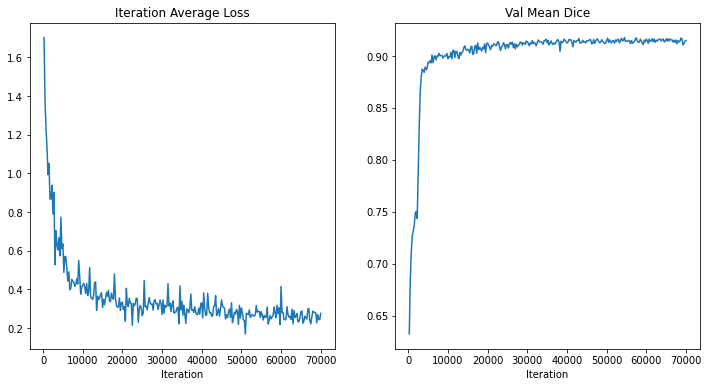

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

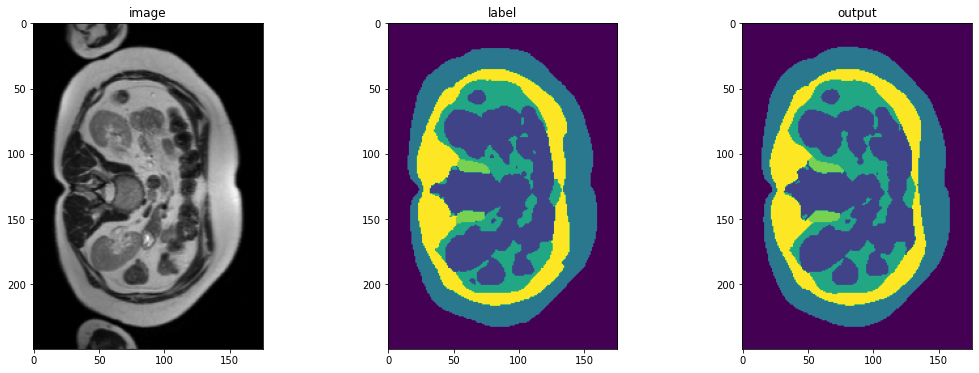

In [13]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR07_swinUNetR_Jan24.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [45]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs/img_setof10", "A043_v5_*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR07_Jan24", output_postfix="seg", resample=False, separate_folder=False),
])

Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


2024-01-16 10:26:27,151 INFO image_writer.py:194 - writing: outMR07_Jan24/A043_v5_T2W_seg.nii.gz


Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


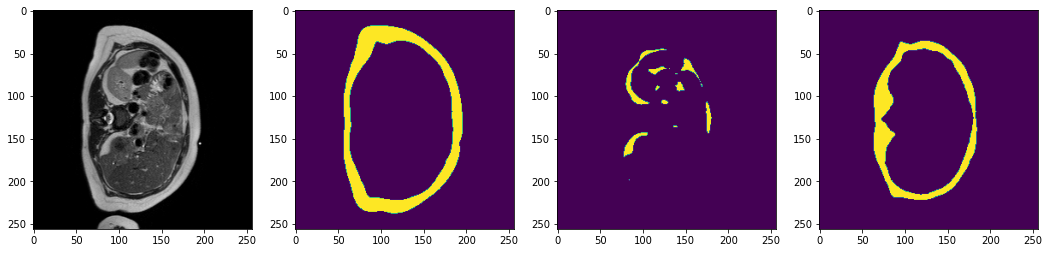

In [47]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR07_swinUNetR_Jan24.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [48]:
!tar -cvzf outMR07_Jan24_swinunetr.tar.gz outMR07_Jan24

outMR07_Jan24/
outMR07_Jan24/A026_v1_T2W_seg.nii.gz
outMR07_Jan24/A033_v3_T2W_seg.nii.gz
outMR07_Jan24/A043_v5_T2W_seg.nii.gz
outMR07_Jan24/A051_v2_T2W_seg.nii.gz
outMR07_Jan24/A009_v4_T2W_seg.nii.gz
outMR07_Jan24/A002_v3_T2W_seg.nii.gz
outMR07_Jan24/A029_v4_T2W_seg.nii.gz
outMR07_Jan24/.ipynb_checkpoints/
